# Toxicity Detection - Baseline Model
### Baseline Model: Logistic Regression + TF-IDF
## **Goal:** Establish a strong baseline for toxicity detection
### **Approach:**
### 1. Preprocess text (lowercase, clean URLs, handle emojis)
### 2. Extract TF-IDF features (unigrams + bigrams)
### 3. Train multi-label Logistic Regression
### 4. Evaluate per-class performance
### 5. Conduct initial error analysis

### Imports

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, multilabel_confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

### 1. Load and Split Data

In [2]:
# Load data
train_df = pd.read_csv('../data/train.csv')
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print(f"Total samples: {len(train_df):,}")
print(f"Label distribution:")
for col in label_cols:
    count = train_df[col].sum()
    pct = count / len(train_df) * 100
    print(f"  {col:15s}: {count:6,} ({pct:5.2f}%)")

Total samples: 159,571
Label distribution:
  toxic          : 15,294 ( 9.58%)
  severe_toxic   :  1,595 ( 1.00%)
  obscene        :  8,449 ( 5.29%)
  threat         :    478 ( 0.30%)
  insult         :  7,877 ( 4.94%)
  identity_hate  :  1,405 ( 0.88%)


In [3]:
# Stratified train/val split (80/20)
train_data, val_data = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['toxic'],  # Stratify on main toxic label
    random_state=42
)

print(f"\nTrain set: {len(train_data):,} samples ({len(train_data)/len(train_df)*100:.1f}%)")
print(f"Val set:   {len(val_data):,} samples ({len(val_data)/len(train_df)*100:.1f}%)")

# Verify stratification
print("\nToxic distribution:")
print(f"  Train: {train_data['toxic'].mean()*100:.2f}%")
print(f"  Val:   {val_data['toxic'].mean()*100:.2f}%")



Train set: 127,656 samples (80.0%)
Val set:   31,915 samples (20.0%)

Toxic distribution:
  Train: 9.58%
  Val:   9.58%


### 2. Text Preprocessing

In [4]:
def clean_text(text):
    """ Clean text for baseline model """
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Lowercase
    text = text.lower()
    
    return text.strip()

# Apply preprocessing
train_data['cleaned_text'] = train_data['comment_text'].apply(clean_text)
val_data['cleaned_text'] = val_data['comment_text'].apply(clean_text)


print("\n Preprocessing complete")


 Preprocessing complete


 ### 3. Feature Extraction - TF-IDF

In [5]:
print("Extracting TF-IDF features...")

# Initialize vectorizer
vectorizer = TfidfVectorizer(
    max_features=10000,      # Top 10k features
    ngram_range=(1, 2),      # Unigrams + bigrams
    min_df=5,                # Ignore rare terms
    max_df=0.8,              # Ignore very common terms
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True        # Apply sublinear tf scaling
)

# Fit on train, transform both
X_train = vectorizer.fit_transform(train_data['cleaned_text'])
X_val = vectorizer.transform(val_data['cleaned_text'])

y_train = train_data[label_cols].values
y_val = val_data[label_cols].values

print(f"\n TF-IDF matrix shape: {X_train.shape}")
print(f"  Features: {len(vectorizer.get_feature_names_out()):,}")
print(f"  Sparsity: {(1.0 - X_train.nnz / (X_train.shape[0] * X_train.shape[1]))*100:.2f}%")

# Most important features by label
feature_names = vectorizer.get_feature_names_out()

print("\nTop TF-IDF features (first 20):")
print(list(feature_names[:20]))

# Save vectorizer
import os
os.makedirs('../models', exist_ok=True)
joblib.dump(vectorizer, '../models/tfidf_vectorizer.pkl')
print("\n Saved: models/tfidf_vectorizer.pkl")

Extracting TF-IDF features...

 TF-IDF matrix shape: (127656, 10000)
  Features: 10,000
  Sparsity: 99.37%

Top TF-IDF features (first 20):
['0', '00', '000', '01', '02', '03', '04', '05', '06', '07', '08', '09', '1', '1 2', '1 the', '10', '100', '100 cellpadding', '100 style', '1000']

 Saved: models/tfidf_vectorizer.pkl


### 4. Train Baseline Model

In [6]:
print("TRAINING BASELINE MODEL")

# Configure model
model = OneVsRestClassifier(
    LogisticRegression(
        C=4.0,                    # Regularization strength
        solver='lbfgs',
        max_iter=200,
        class_weight='balanced',  # Handle class imbalance
        random_state=42,
        n_jobs=-1
    )
)

print("\nTraining Logistic Regression (OneVsRest)...")
print("This may take 1-2 minutes...\n")

model.fit(X_train, y_train)

print("Training complete!")

# Save model
joblib.dump(model, '../models/baseline_lr_model.pkl')
print("Saved: models/baseline_lr_model.pkl")


TRAINING BASELINE MODEL

Training Logistic Regression (OneVsRest)...
This may take 1-2 minutes...

Training complete!
Saved: models/baseline_lr_model.pkl


### 5. Predictions

In [7]:
print("Making predictions on validation set...")

y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)

print(" Predictions complete")

Making predictions on validation set...
 Predictions complete


### 6. Evaluation Metrics

In [8]:
print("EVALUATION RESULTS")

# Overall metrics
print("\nOVERALL METRICS :")
hamming_loss = 1 - accuracy_score(y_val, y_pred)
exact_match = accuracy_score(y_val, y_pred)
macro_f1 = f1_score(y_val, y_pred, average='macro')
micro_f1 = f1_score(y_val, y_pred, average='micro')

print(f"Hamming Loss:      {hamming_loss:.4f}")
print(f"Exact Match Ratio: {exact_match:.4f}")
print(f"Macro F1:          {macro_f1:.4f}")
print(f"Micro F1:          {micro_f1:.4f}")

# %%
# Per-class metrics
print("\n PER-CLASS METRICS ")
print(f"{'Label':<15} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'ROC-AUC':>10} {'Support':>10}")
print("-" * 75)

metrics_list = []

for i, label in enumerate(label_cols):
    precision = precision_score(y_val[:, i], y_pred[:, i], zero_division=0)
    recall = recall_score(y_val[:, i], y_pred[:, i], zero_division=0)
    f1 = f1_score(y_val[:, i], y_pred[:, i], zero_division=0)
    
    # ROC-AUC
    try:
        roc_auc = roc_auc_score(y_val[:, i], y_pred_proba[i][:, 1])
    except:
        roc_auc = 0.0
    
    support = int(y_val[:, i].sum())
    
    print(f"{label:<15} {precision:>10.3f} {recall:>10.3f} {f1:>10.3f} {roc_auc:>10.3f} {support:>10,}")
    
    metrics_list.append({
        'Label': label,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Support': support
    })

metrics_df = pd.DataFrame(metrics_list)

# %%
# Save metrics
os.makedirs('../results', exist_ok=True)
metrics_df.to_csv('../results/baseline_metrics.csv', index=False)
print("\n Saved: results/baseline_metrics.csv")

EVALUATION RESULTS

OVERALL METRICS :
Hamming Loss:      0.1390
Exact Match Ratio: 0.8610
Macro F1:          0.5288
Micro F1:          0.6450

 PER-CLASS METRICS 
Label            Precision     Recall   F1-Score    ROC-AUC    Support
---------------------------------------------------------------------------
toxic                0.595      0.862      0.704      0.000      3,059
severe_toxic         0.277      0.814      0.414      0.000        311
obscene              0.621      0.867      0.724      0.000      1,710
threat               0.235      0.670      0.348      0.000         97
insult               0.516      0.854      0.643      0.000      1,590
identity_hate        0.224      0.706      0.341      0.000        289

 Saved: results/baseline_metrics.csv


### 7. Visualizations

### Plot 1: F1 scores by label

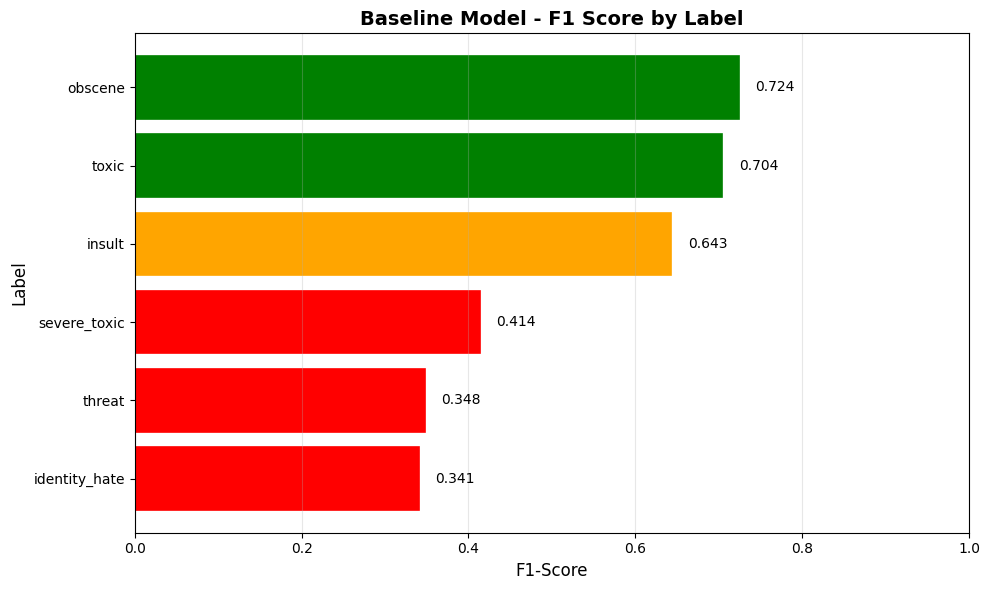

 Saved: results/baseline_f1_scores.png


In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

metrics_df_sorted = metrics_df.sort_values('F1-Score', ascending=True)
bars = ax.barh(metrics_df_sorted['Label'], metrics_df_sorted['F1-Score'], 
               color='steelblue', edgecolor='black', linewidth=1.2)

# Color code by performance
colors = ['red' if x < 0.5 else 'orange' if x < 0.7 else 'green' 
          for x in metrics_df_sorted['F1-Score']]
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax.set_xlabel('F1-Score', fontsize=12)
ax.set_ylabel('Label', fontsize=12)
ax.set_title('Baseline Model - F1 Score by Label', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, 1)

# Add value labels
for i, (idx, row) in enumerate(metrics_df_sorted.iterrows()):
    ax.text(row['F1-Score'] + 0.02, i, f"{row['F1-Score']:.3f}", 
            va='center', fontsize=10)

plt.tight_layout()
plt.savefig('../results/baseline_f1_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Saved: results/baseline_f1_scores.png")

 ### Plot 2: Precision vs Recall scatter

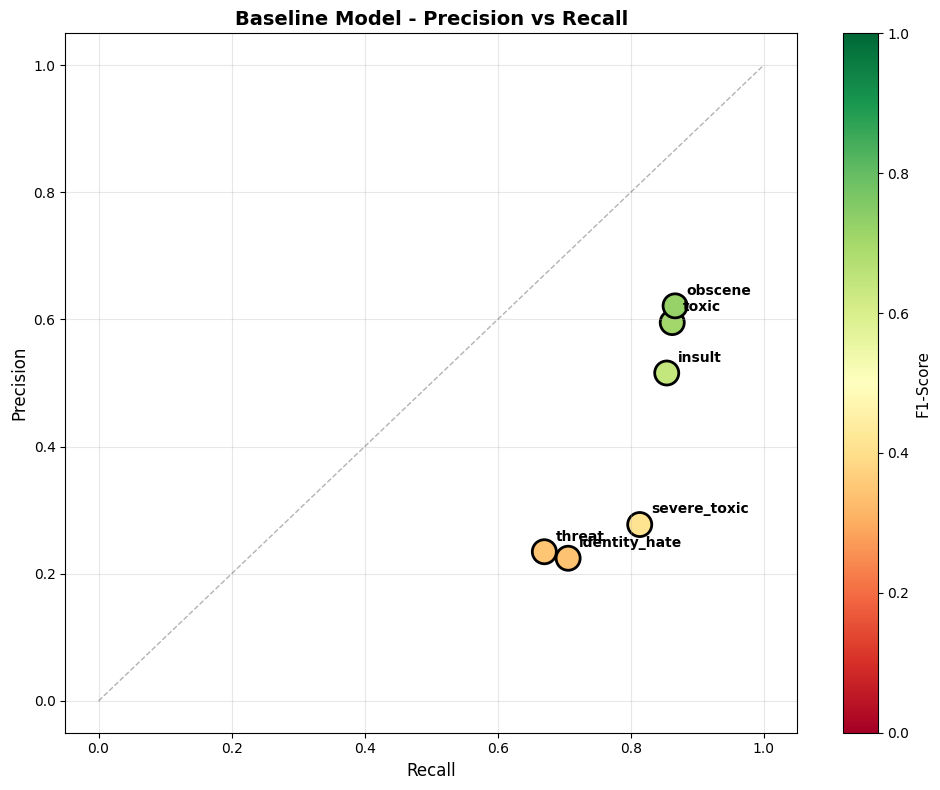

Saved: results/baseline_precision_recall.png


In [10]:
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(metrics_df['Recall'], metrics_df['Precision'], 
                     s=300, c=metrics_df['F1-Score'], cmap='RdYlGn', 
                     edgecolors='black', linewidth=2, vmin=0, vmax=1)

# Annotate points
for idx, row in metrics_df.iterrows():
    ax.annotate(row['Label'], 
                (row['Recall'], row['Precision']),
                xytext=(8, 8), textcoords='offset points', 
                fontsize=10, fontweight='bold')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Baseline Model - Precision vs Recall', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# Add diagonal line (F1 = constant)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('F1-Score', fontsize=11)

plt.tight_layout()
plt.savefig('../results/baseline_precision_recall.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: results/baseline_precision_recall.png")

### Plot 3: Confusion matrices

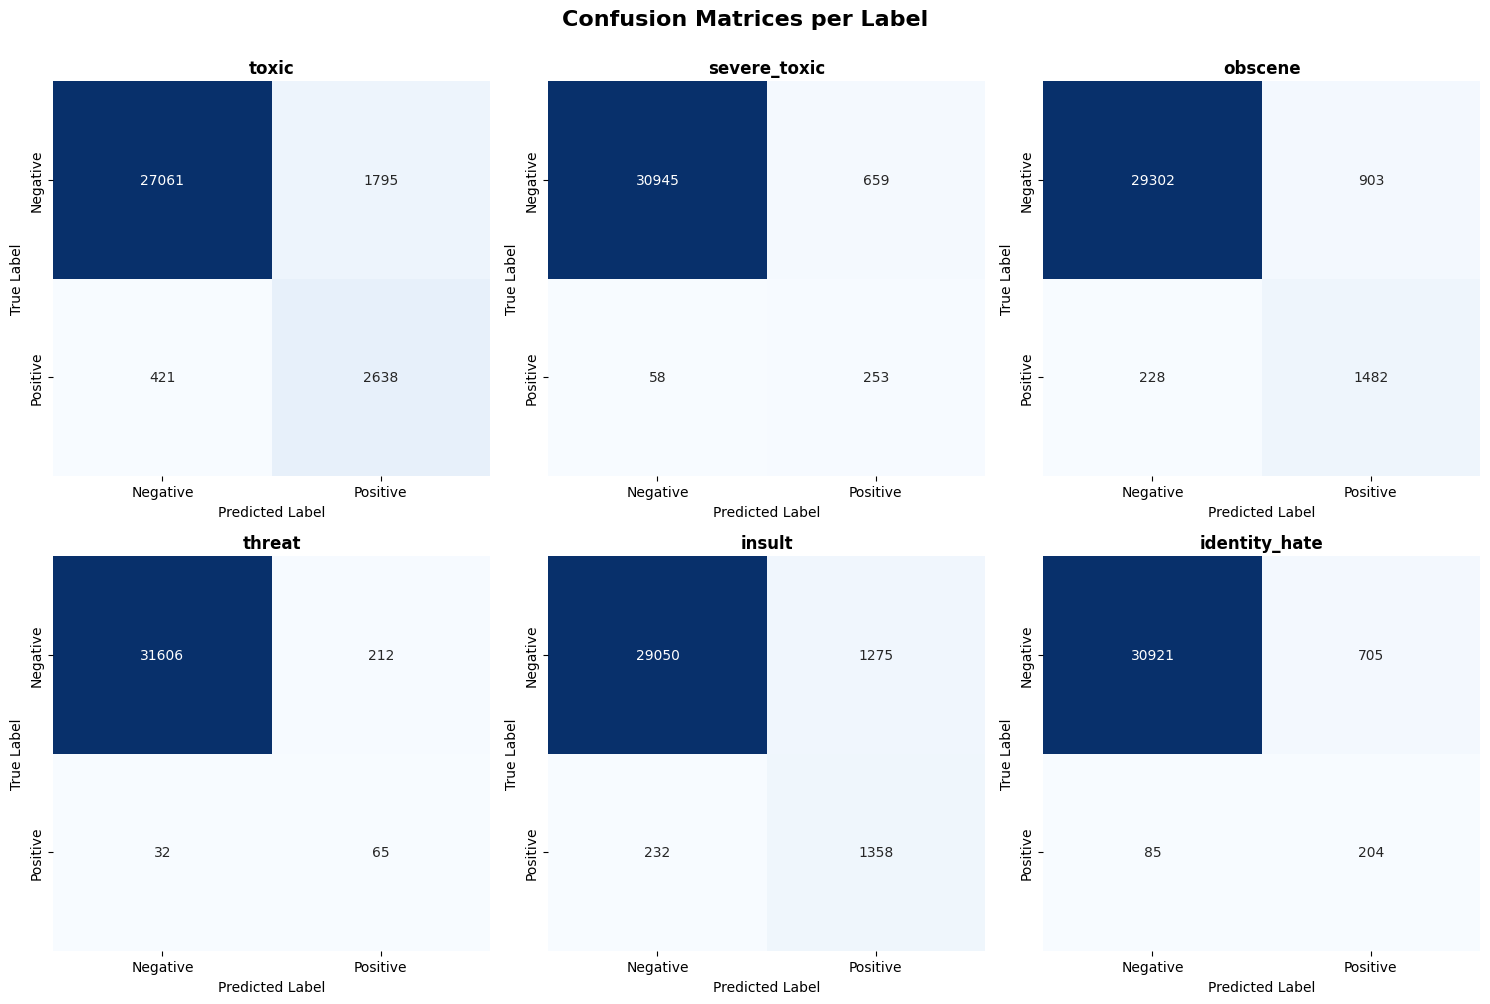

 Saved: results/baseline_confusion_matrices.png


In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

cm_multi = multilabel_confusion_matrix(y_val, y_pred)

for i, (label, cm) in enumerate(zip(label_cols, cm_multi)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                cbar=False)
    axes[i].set_title(f'{label}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('True Label', fontsize=10)
    axes[i].set_xlabel('Predicted Label', fontsize=10)

plt.suptitle('Confusion Matrices per Label', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../results/baseline_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Saved: results/baseline_confusion_matrices.png")

### 8. Error Analysis

In [12]:
# Create results dataframe
val_results = val_data.copy().reset_index(drop=True)

for i, label in enumerate(label_cols):
    val_results[f'{label}_pred'] = y_pred[:, i]
    
    proba_array = y_pred_proba[i]
    
    if hasattr(proba_array, 'shape') and len(proba_array.shape) == 2:
        val_results[f'{label}_proba'] = proba_array[:, 1]
    else:
        val_results[f'{label}_proba'] = model.estimators_[i].decision_function(X_val)

print(" Results dataframe created")
print(f"Shape: {val_results.shape}")
print(f"Columns: {[col for col in val_results.columns if '_proba' in col]}")


# FALSE POSITIVES: Predicted toxic, actually clean
print("\n--- FALSE POSITIVES (Predicted Toxic, Actually Clean) ---")
fp_mask = (val_results['toxic_pred'] == 1) & (val_results['toxic'] == 0)
fp_samples = val_results[fp_mask].nlargest(5, 'toxic_proba')

print(f"\nTotal false positives: {fp_mask.sum():,}\n")

for idx, row in fp_samples.iterrows():
    print(f"Text: {row['comment_text'][:200]}...")
    print(f"Predicted probability: {row['toxic_proba']:.3f}")
    print(f"True labels: {[col for col in label_cols if row[col] == 1]}")

# FALSE NEGATIVES: Predicted clean, actually toxic
print("\n--- FALSE NEGATIVES (Predicted Clean, Actually Toxic) ---")
fn_mask = (val_results['toxic_pred'] == 0) & (val_results['toxic'] == 1)
fn_samples = val_results[fn_mask].nsmallest(5, 'toxic_proba')

print(f"\nTotal false negatives: {fn_mask.sum():,}\n")

for idx, row in fn_samples.iterrows():
    print(f"Text: {row['comment_text'][:200]}...")
    print(f"Predicted probability: {row['toxic_proba']:.3f}")
    print(f"True labels: {[col for col in label_cols if row[col] == 1]}")

# Save full predictions for deeper analysis
val_results.to_csv('../results/baseline_predictions.csv', index=False)
print("\n Saved: results/baseline_predictions.csv")

 Results dataframe created
Shape: (31915, 21)
Columns: ['toxic_proba', 'severe_toxic_proba', 'obscene_proba', 'threat_proba', 'insult_proba', 'identity_hate_proba']

--- FALSE POSITIVES (Predicted Toxic, Actually Clean) ---

Total false positives: 1,795

Text: Message

Hey Dx927 you're a fat ugly cunt with the mental capacity of a 3-year-old amoeba. Why don't you get a life and stop trolling wikipedia you little fag?...
Predicted probability: 13.849
True labels: ['obscene', 'insult']
Text: Khurki is a dumb Assk Jeeves?...
Predicted probability: 9.772
True labels: []
Text: "== hun u dunno wat u talkin about==
""vandalism""? lol...i am correcting misconceptions because unlike you dumb ass wikipedia users, i KNOW my facts...so stop sending me harrressing messages god leav...
Predicted probability: 9.409
True labels: []
Text: Shutup 

[[Who U think U is you gay nobody thats why you got that userbox your orientation doesn't affect you cuz you tried to sleep with Chris brown, he don't want u

### 9. Summary

In [13]:
print("BASELINE MODEL SUMMARY")

summary = {
    'model': 'Logistic Regression (OneVsRest)',
    'features': 'TF-IDF (max_features=10000, ngram_range=(1,2))',
    'train_samples': len(train_data),
    'val_samples': len(val_data),
    'macro_f1': float(macro_f1),
    'micro_f1': float(micro_f1),
    'exact_match_ratio': float(exact_match),
    'hamming_loss': float(hamming_loss),
    'per_class_f1': metrics_df.set_index('Label')['F1-Score'].to_dict()
}

# Display
print(f"""
Model: {summary['model']}
Features: {summary['features']}

Performance:
  Macro F1:     {summary['macro_f1']:.4f}
  Micro F1:     {summary['micro_f1']:.4f}
  Exact Match:  {summary['exact_match_ratio']:.4f}
  Hamming Loss: {summary['hamming_loss']:.4f}

Best performing labels:
""")

top_3 = metrics_df.nlargest(3, 'F1-Score')
for idx, row in top_3.iterrows():
    print(f"  {row['Label']:15s}: F1 = {row['F1-Score']:.3f}")

print("\nWorst performing labels:")
bottom_3 = metrics_df.nsmallest(3, 'F1-Score')
for idx, row in bottom_3.iterrows():
    print(f"  {row['Label']:15s}: F1 = {row['F1-Score']:.3f}")

# Save summary
import json
with open('../results/baseline_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n Saved: results/baseline_summary.json")


BASELINE MODEL SUMMARY

Model: Logistic Regression (OneVsRest)
Features: TF-IDF (max_features=10000, ngram_range=(1,2))

Performance:
  Macro F1:     0.5288
  Micro F1:     0.6450
  Exact Match:  0.8610
  Hamming Loss: 0.1390

Best performing labels:

  obscene        : F1 = 0.724
  toxic          : F1 = 0.704
  insult         : F1 = 0.643

Worst performing labels:
  identity_hate  : F1 = 0.341
  threat         : F1 = 0.348
  severe_toxic   : F1 = 0.414

 Saved: results/baseline_summary.json
